<a href="https://colab.research.google.com/github/Marcusk01/MNIST-prediction/blob/main/Mnist_fashion_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import numpy as np
import os
import shutil
import glob
homedir=os.path.expanduser("~")

Data preparation

In [61]:
# Kaggle API token

! pip install -q kaggle
from google.colab import files
files.upload()

data_path = homedir+'/data'

os.makedirs(homedir+'/.kaggle',exist_ok = True)
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
os.system('kaggle competitions download -c mais202fall2021 -p '+data_path)
! cd data
fname_zip = glob.glob('*.zip')
for i in range(len(fname_zip)):
    shutil.unpack_archive(fname_zip[i], './data')


Saving kaggle.json to kaggle (7).json


In [64]:
# show_image function 

import matplotlib.pyplot as plt

def show_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest',cmap='bwr')
    plt.show()


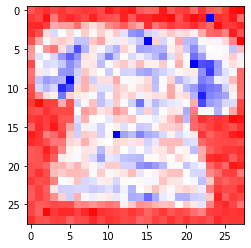

In [65]:
x_train = np.load('/content/data/train_images.npy')
y_train = pd.read_csv('/content/data/train_labels.csv')

show_image(x_train[0])